In [ ]:
# Ignore errors from this cell. Autosklearn doesn't play well with TPOT's dependecies (sklearn) but still works
! apt-get remove swig
! apt-get install swig3.0
! ln -s /usr/bin/swig3.0 /usr/bin/swig
! wget https://gitlab.com/PranavRai/automl-with-tpot/-/raw/master/requirements.txt
! pip install -r requirements.txt
! pip install -U --upgrade pandas-profiling

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'swig' is not installed, so not removed
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig3.0 is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
ln: failed to create symbolic link '/usr/bin/swig': File exists
--2020-06-17 19:33:35--  https://gitlab.com/PranavRai/automl-with-tpot/-/raw/master/requirements.txt
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... 

In [ ]:
import openml as oml
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from autosklearn.classification import AutoSklearnClassifier
import h2o
from h2o.automl import H2OAutoML

import pandas as pd
import pandas_profiling
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")

replicates = 2
h2o.init()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8y9m62vc
  JVM stdout: /tmp/tmp8y9m62vc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8y9m62vc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.0.2
H2O cluster version age:    4 months and 28 days !!!
H2O cluster name:           H2O_from_python_unknownUser_io9tir
H2O cluster total nodes:    1
H2O cluster free memory:    3.180 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

## Generating Data Analysis Reports

In [ ]:
def generate_profile(data: pd.DataFrame, dataset_name: str):
    """
    Generates pandas profile report for the dataset
    :param data: Pandas dataframe
    :return:
    """
    filename = f'{dataset_name}.html'
    print(data)
    if not os.path.isfile(filename):
        profile = data.profile_report()
        profile.to_file(output_file=filename)

## Imputing Missing Values with Median
## Train Test Splitting

In [ ]:
def build(dataset_name: str):
    """
    Load data, impute Missing Values with medians (numeric only!), split into 
    train-test and return
    :param dataset_name: String
    :return: X, Y, and train-test indices
    """
    dataset = oml.datasets.get_dataset(dataset_name)
    
    print("Dataset:'%s', Target Feature:'%s'\n\n" % 
      (dataset.name, dataset.default_target_attribute))

    X, Y, _ , attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(X)
    X = imp_median.transform(X)

    le = LabelEncoder()
    le.fit(Y)

    X = pd.DataFrame(X, columns=attribute_names)
    generate_profile(data=pd.concat([X, pd.DataFrame(Y, columns=["Class"])], 
                                    axis=1), dataset_name=dataset_name)
    Y = pd.DataFrame(le.transform(Y), columns=["Class"]).squeeze()
    
    training_indices, test_indices = train_test_split(X.index, stratify = Y, 
                                                      train_size=0.75, 
                                                      test_size=0.25, 
                                                      random_state=4242123)
    return (X, Y, training_indices, test_indices)

# Random Forest

In [ ]:
def model_rf(data, replicates: int=4):
    """
    Perform Random Forest with Random Search Hypertuning
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(5, 20, num = 3)]
    max_depth.append(None)
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 4]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    for count in range(replicates):
        rf = RandomForestClassifier(random_state=(count + 1) * 42420)
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                       cv = 3, verbose=2, random_state=(count + 1) * 42421231, n_jobs = -1)
        rf_random.fit(X.loc[training_indices], Y.loc[training_indices])
        pred_labels = rf_random.predict(X.loc[test_indices])
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
    
    output_log = f"\n{replicates} Random Forest Models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"
    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)


# TPOT

In [ ]:
def model_tpot(data, replicates: int=4):
    """
    Perform TPOT AutoML operation
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    for count in range(replicates):        
        pipeline_optimizer = TPOTClassifier(generations=4, population_size=70, cv=3, max_time_mins=4, 
                                        max_eval_time_mins=1, random_state=(count + 1) * 42985, verbosity=2, 
                                            n_jobs=-1)
        pipeline_optimizer.fit(X.loc[training_indices], Y.loc[training_indices])
        pred_labels = pipeline_optimizer.predict(X.loc[test_indices])
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
    
    output_log = f"\n{replicates} TPOT Models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"
    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)

# AutoSklearn

In [ ]:
def model_autosklearn(data, replicates: int=4):
    """
    Perform AutoSklearn AutoML operation
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    
    for count in range(replicates):
        model_autosk = AutoSklearnClassifier(time_left_for_this_task=4 * 60, per_run_time_limit=1 * 60, n_jobs=4,
                                            seed=4242 * (count + 1))
        model_autosk.fit(X.loc[training_indices], Y.loc[training_indices])
        pred_labels = model_autosk.predict(X.loc[test_indices])
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
        
    output_log = f"\n{replicates} AutoSKLearn Models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"

    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)

# H20

In [ ]:
def model_h20(data, replicates: int=4):
    """
    Perform h2o AutoML operation
    :param data: X, Y, train indices, test indices
    :param replicates: How many times to run the algorithm
    :return: output log (str), mean F1 macro, mean Acc
    """
    t0 = time.time()
    X, Y, training_indices, test_indices = data
    f1, acc = [], []
    train_frame = h2o.H2OFrame(pd.concat([X, Y], axis=1).loc[training_indices])
    train_frame[:,-1] = train_frame[:,-1].asfactor()
    test_frame = h2o.H2OFrame(pd.concat([X, Y], axis=1).loc[test_indices])
    test_frame[:,-1] = test_frame[:,-1].asfactor()
    
    for count in range(replicates):
        model_h20 = H2OAutoML(max_models=8, seed=4242 * (count + 1), max_runtime_secs=4 * 60, 
                              max_runtime_secs_per_model = 60)
        model_h20.train(x=list(X.columns), y="Class", training_frame=train_frame)
        pred_labels = model_h20.predict(test_frame).as_data_frame().iloc[:,0]
        
        f1.append(f1_score(Y.loc[test_indices], pred_labels, average="macro"))
        acc.append(accuracy_score(Y.loc[test_indices], pred_labels))
        
    output_log = f"\n{replicates} H20 models in {round(time.time()-t0, 1)} seconds\n"
    output_log += f"\tF1-macro: {round(np.mean(f1), 4)} ± {round(np.std(f1), 4)}"
    output_log += f"\tAccuracy: {round(np.mean(acc), 4)} ± {round(np.std(acc), 4)}\n"
    print(output_log)
    return output_log, np.mean(f1), np.mean(acc)

In [ ]:
logs_all = []
f1_all, acc_all = [], []
datasets = ["segment", "blood-transfusion-service-center", "vehicle", 
            "car-evaluation", "breast-w", "phoneme", "collins"]
 
def evaluate_one_dataset(dataset_name):
    """
    Evaluate this dataset for all algorithms, and store results
    :param dataset_name: String
    :return: 
    """
    data = build(dataset_name)
    log_rf, f_rf, acc_rf = model_rf(data, replicates=replicates)
    log_sk, f_sk, acc_sk = model_autosklearn(data, replicates=replicates)
    log_h2o, f_h2o, acc_h2o = model_h20(data, replicates=replicates)
    log_tpot, f_tpot, acc_tpot = model_tpot(data, replicates=replicates)

    acc_all.append((acc_rf, acc_sk, acc_h2o, acc_tpot))
    f1_all.append((f_rf, f_sk, f_h2o, f_tpot))
    logs_all.append((log_rf, log_sk, log_h2o, log_tpot))
    # 1'08am

# Evaluating Datasets


In [ ]:
evaluate_one_dataset(datasets[0])

DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.


Dataset:'segment', Target Feature:'class'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.2min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.2min finished



2 Random Forest Models in 261.9 seconds
	F1-macro: 0.987 ± 0.0009	Accuracy: 0.987 ± 0.0009

[WARNING] [2020-06-17 19:43:09,435:EnsembleBuilder(1395647406):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 19:43:09,493:EnsembleBuilder(1395647406):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 19:44:29,194:EnsembleBuilder(1395647406):89f044edf1985fc48bf81ce1b447cf9e] Memory Exception -- restart with less ensemle_nbest: 25
[WARNING] [2020-06-17 19:48:25,089:EnsembleBuilder(2926526486):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 19:48:25,143:EnsembleBuilder(2926526486):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 19:48:27,172:EnsembleBuilder(2926526486):89f044edf1985fc48bf81ce1b447cf9e] No models better than random - using Dummy Score!

2 AutoSKLearn Mode

Generation 1 - Current best internal CV score: 0.9745981581540762

4.23 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=8, n_estimators=100, nthread=1, subsample=1.0)


Generation 1 - Current best internal CV score: 0.9728620574542388

4.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=8, max_features=0.5, min_samples_leaf=3, min_samples_split=5, n_estimators=100, subsample=0.55)

2 TPOT Models in 512.5 seconds
	F1-macro: 0.9836 ± 0.0008	Accuracy: 0.9836 ± 0.0009



In [ ]:
evaluate_one_dataset(datasets[1])

Dataset:'blood-transfusion-service-center', Target Feature:'Class'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.3min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.3min finished



2 Random Forest Models in 154.4 seconds
	F1-macro: 0.6975 ± 0.0157	Accuracy: 0.8182 ± 0.0053

[WARNING] [2020-06-17 20:10:39,960:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:10:40,024:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:10:42,063:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:10:44,095:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:10:46,130:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:10:48,160:EnsembleBuilder(1395647406):a98fcc2fe8253f2584b35ee513e03faf] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 2

Generation 1 - Current best internal CV score: 0.7754010695187166
Generation 2 - Current best internal CV score: 0.7754010695187166
Generation 3 - Current best internal CV score: 0.7754010695187166
Generation 4 - Current best internal CV score: 0.7914438502673797

Best pipeline: RandomForestClassifier(FastICA(FastICA(input_matrix, tol=0.4), tol=0.65), bootstrap=True, criterion=entropy, max_features=0.1, min_samples_leaf=7, min_samples_split=7, n_estimators=100)


Generation 1 - Current best internal CV score: 0.7736185383244206
Generation 2 - Current best internal CV score: 0.7736185383244206
Generation 3 - Current best internal CV score: 0.7771836007130125
Generation 4 - Current best internal CV score: 0.7807486631016043

Best pipeline: DecisionTreeClassifier(MultinomialNB(GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=9, max_features=0.3, min_samples_leaf=11, min_samples_split=3, n_estimators=100, subsample=0.5), alpha=0.1, fit_prior=True), criterion=entropy, max_depth=3, min_samples_leaf=18, min_samples_split=13)

2 TPOT Models in 202.2 seconds
	F1-macro: 0.6417 ± 0.0498	Accuracy: 0.7941 ± 0.008



In [ ]:
evaluate_one_dataset(datasets[2])

Dataset:'vehicle', Target Feature:'Class'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.5min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.5min finished



2 Random Forest Models in 179.7 seconds
	F1-macro: 0.7175 ± 0.0069	Accuracy: 0.7288 ± 0.0071

[WARNING] [2020-06-17 20:25:55,246:EnsembleBuilder(1395647406):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:25:55,316:EnsembleBuilder(1395647406):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:29:57,276:EnsembleBuilder(2926526486):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:29:57,314:EnsembleBuilder(2926526486):a3f255acd90e3883f401216537c9bfbb] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:32:00,318:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-06-17 20:32:00,318:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger

2 Auto

Generation 1 - Current best internal CV score: 0.7775939670332946
Generation 2 - Current best internal CV score: 0.7775939670332946
Generation 3 - Current best internal CV score: 0.7791886494381353

4.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(RobustScaler(GaussianNB(input_matrix)), C=10.0, dual=False, penalty=l2)


Generation 1 - Current best internal CV score: 0.7602387552535097
Generation 2 - Current best internal CV score: 0.7697025246654148

4.05 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), learning_rate=0.5, max_depth=9, max_features=0.3, min_samples_leaf=3, min_samples_split=7, n_estimators=100, subsample=0.8500000000000001)

2 TPOT Models in 486.9 seconds
	F1-macro: 0.7921 ± 0.0322	Accuracy: 0.7925 ± 0.033



In [ ]:
evaluate_one_dataset(datasets[3])

Dataset:'car-evaluation', Target Feature:'class'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.4min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.4min finished



2 Random Forest Models in 169.3 seconds
	F1-macro: 0.9272 ± 0.0059	Accuracy: 0.9653 ± 0.0

[WARNING] [2020-06-17 20:46:35,606:EnsembleBuilder(1395647406):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:46:35,657:EnsembleBuilder(1395647406):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:47:37,572:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-06-17 20:47:37,572:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-06-17 20:50:39,506:EnsembleBuilder(2926526486):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 20:50:39,548:EnsembleBuilder(2926526486):b7ea554ce187a13bd731c6b5a675d42b] No models better than random - using Dummy Score!

2 AutoSKL

Generation 1 - Current best internal CV score: 0.9498456790123457
Generation 2 - Current best internal CV score: 0.9560185185185185
Generation 3 - Current best internal CV score: 0.9575617283950617
Generation 4 - Current best internal CV score: 0.9575617283950617

Best pipeline: SGDClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=7, max_features=0.4, min_samples_leaf=10, min_samples_split=7, n_estimators=100, subsample=0.6000000000000001), alpha=0.0, eta0=1.0, fit_intercept=True, l1_ratio=0.75, learning_rate=invscaling, loss=log, penalty=elasticnet, power_t=0.1)


Generation 1 - Current best internal CV score: 0.9606481481481483
Generation 2 - Current best internal CV score: 0.9652777777777777
Generation 3 - Current best internal CV score: 0.9652777777777777

4.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=3, max_features=0.55, min_samples_leaf=5, min_samples_split=9, n_estimators=100, subsample=1.0), bootstrap=False, criterion=gini, max_features=0.7000000000000001, min_samples_leaf=6, min_samples_split=13, n_estimators=100)

2 TPOT Models in 478.0 seconds
	F1-macro: 0.9769 ± 0.0129	Accuracy: 0.9907 ± 0.0046



In [ ]:
evaluate_one_dataset(datasets[4])

Dataset:'breast-w', Target Feature:'Class'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.2min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.2min finished



2 Random Forest Models in 146.3 seconds
	F1-macro: 0.9623 ± 0.0	Accuracy: 0.9657 ± 0.0

[WARNING] [2020-06-17 21:10:03,659:EnsembleBuilder(1395647406):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:10:03,723:EnsembleBuilder(1395647406):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:14:07,219:EnsembleBuilder(2926526486):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:14:07,273:EnsembleBuilder(2926526486):23e489275cb7dc3d1d5ea7471c26b1c4] No models better than random - using Dummy Score!

2 AutoSKLearn Models in 487.6 seconds
	F1-macro: 0.9621 ± 0.0001	Accuracy: 0.9657 ± 0.0

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |█████████████████████████████████████████████████████

Generation 1 - Current best internal CV score: 0.9752052545155993
Generation 2 - Current best internal CV score: 0.9770990695128626
Generation 3 - Current best internal CV score: 0.9790038314176245
Generation 4 - Current best internal CV score: 0.9790038314176245

Best pipeline: RandomForestClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=8, max_features=0.1, min_samples_leaf=4, min_samples_split=9, n_estimators=100, subsample=0.8500000000000001), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=14, min_samples_split=16, n_estimators=100)


Generation 1 - Current best internal CV score: 0.9732895457033388
Generation 2 - Current best internal CV score: 0.9732895457033388
Generation 3 - Current best internal CV score: 0.9751943076081006
Generation 4 - Current best internal CV score: 0.9751943076081006

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=6, max_features=0.1, min_samples_leaf=2, min_samples_split=9, n_estimators=100, subsample=0.8500000000000001)

2 TPOT Models in 213.2 seconds
	F1-macro: 0.9684 ± 0.0	Accuracy: 0.9714 ± 0.0



In [ ]:
evaluate_one_dataset(datasets[5])

Dataset:'phoneme', Target Feature:'Class'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.4min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.4min finished



2 Random Forest Models in 412.2 seconds
	F1-macro: 0.8808 ± 0.0032	Accuracy: 0.9023 ± 0.0022

[WARNING] [2020-06-17 21:29:26,274:EnsembleBuilder(1395647406):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:29:26,334:EnsembleBuilder(1395647406):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:33:26,474:EnsembleBuilder(2926526486):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:33:26,516:EnsembleBuilder(2926526486):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:33:28,547:EnsembleBuilder(2926526486):86d08913e1f8ea4c12db3946c775175c] No models better than random - using Dummy Score!

2 AutoSKLearn Models in 479.7 seconds
	F1-macro: 0.8708 ± 0.0004	Accuracy: 0.8934 ± 0.0

Parse progress: |█████████████████████████████████████████████████████████| 100%

Generation 1 - Current best internal CV score: 0.8921786331112757
Generation 2 - Current best internal CV score: 0.8921786331112757

4.00 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.4, min_samples_leaf=3, min_samples_split=4, n_estimators=100)


Generation 1 - Current best internal CV score: 0.8887244016777696
Generation 2 - Current best internal CV score: 0.8931655563779916

4.13 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVC(RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.4, min_samples_leaf=1, min_samples_split=2, n_estimators=100), C=5.0, dual=False, loss=squared_hinge, penalty=l2, tol=1e-05)

2 TPOT Models in 494.4 seconds
	F1-macro: 0.8765 ± 0.0049	Accuracy: 0.8986 ± 0.0037



In [ ]:
evaluate_one_dataset(datasets[6])

Dataset:'collins', Target Feature:'binaryClass'


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.2min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.3min finished



2 Random Forest Models in 151.9 seconds
	F1-macro: 0.9845 ± 0.0155	Accuracy: 0.992 ± 0.008

[WARNING] [2020-06-17 21:51:07,703:EnsembleBuilder(1395647406):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:51:07,773:EnsembleBuilder(1395647406):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:55:12,538:EnsembleBuilder(2926526486):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!
[WARNING] [2020-06-17 21:55:12,571:EnsembleBuilder(2926526486):dc0b9e9f2cb446c8ee3c2fc1575abce7] No models better than random - using Dummy Score!

2 AutoSKLearn Models in 485.5 seconds
	F1-macro: 1.0 ± 0.0	Accuracy: 1.0 ± 0.0

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 

Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.4, min_samples_leaf=3, min_samples_split=4, n_estimators=100)


Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=89, p=2, weights=distance)

2 TPOT Models in 298.0 seconds
	F1-macro: 1.0 ± 0.0	Accuracy: 1.0 ± 0.0



In [ ]:
for dataset_name, logs in zip(datasets, logs_all):
    print(dataset_name)
    for log in logs:
        print(log)
    print("\n\n\n")

segment

2 Random Forest Models in 261.9 seconds
	F1-macro: 0.987 ± 0.0009	Accuracy: 0.987 ± 0.0009


2 AutoSKLearn Models in 553.7 seconds
	F1-macro: 0.9818 ± 0.0043	Accuracy: 0.9818 ± 0.0043


2 H20 models in 429.1 seconds
	F1-macro: 0.9887 ± 0.0043	Accuracy: 0.9888 ± 0.0043


2 TPOT Models in 512.5 seconds
	F1-macro: 0.9836 ± 0.0008	Accuracy: 0.9836 ± 0.0009





blood-transfusion-service-center

2 Random Forest Models in 154.4 seconds
	F1-macro: 0.6975 ± 0.0157	Accuracy: 0.8182 ± 0.0053


2 AutoSKLearn Models in 492.2 seconds
	F1-macro: 0.6582 ± 0.0826	Accuracy: 0.8048 ± 0.0241


2 H20 models in 38.8 seconds
	F1-macro: 0.6989 ± 0.0	Accuracy: 0.7487 ± 0.0


2 TPOT Models in 202.2 seconds
	F1-macro: 0.6417 ± 0.0498	Accuracy: 0.7941 ± 0.008





vehicle

2 Random Forest Models in 179.7 seconds
	F1-macro: 0.7175 ± 0.0069	Accuracy: 0.7288 ± 0.0071


2 AutoSKLearn Models in 481.5 seconds
	F1-macro: 0.8191 ± 0.0046	Accuracy: 0.8231 ± 0.0024


2 H20 models in 102.6 seconds
	F1-macro: 0.817

# Plotting

In [ ]:
import matplotlib.pyplot as plt
def plot_all(dataset_name, f1, acc):
    
    labels = ['Random_forest', 'Auto_sklearn', 'h20', 'Tpot']
    f1, acc = list(f1), list(acc)

    x = np.arange(len(labels)) 
    width = 0.5
    y_lim_1 = [max(round(np.mean(f1), 1) - 0.2, 0), min(np.mean(f1) + 0.2, 1)]
    y_lim_2 = [max(round(np.mean(acc), 1) - 0.2, 0), min(np.mean(acc) + 0.2, 1)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].bar(labels, f1, color="blue", width=width)
    axs[0].set_xticks(x)
    axs[0].set_yticks(np.arange(y_lim_1[0], y_lim_1[1], step=0.1))
    axs[0].set_ylim(y_lim_1)
    axs[0].set_ylabel('F1 Micro score')

    axs[0].set_title(dataset_name)
    

    axs[1].bar(labels, acc, color="green", width=width)
    axs[1].set_xticks(x)
    axs[1].set_yticks(np.arange(y_lim_2[0], y_lim_2[1], step=0.1))
    axs[1].set_ylim(y_lim_2)
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title(dataset_name)
    # fig.tight_layout()

    plt.show()

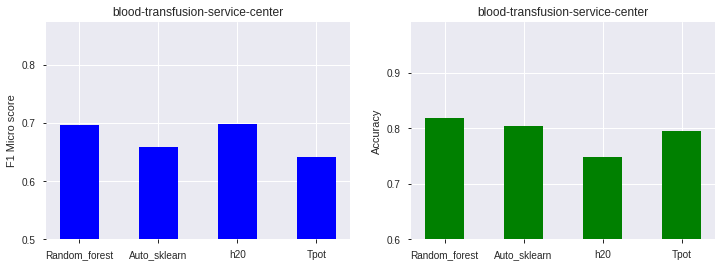

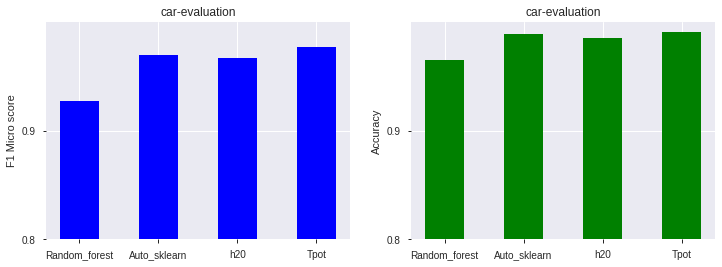

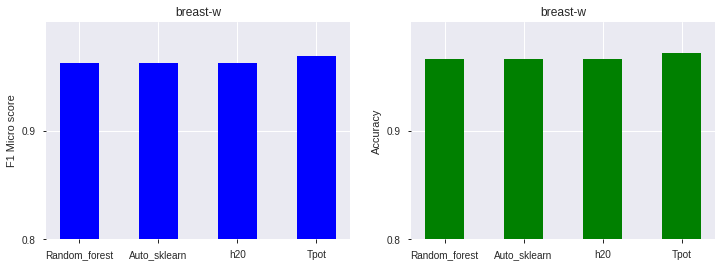

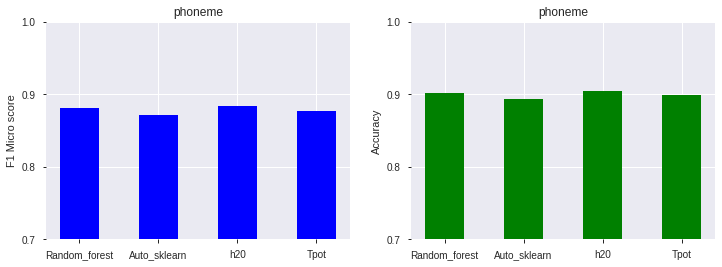

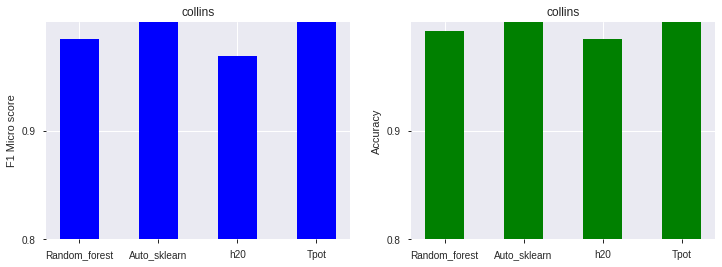

In [ ]:
for dataset_name, f1, acc in zip(datasets, f1_all, acc_all):
    plot_all(dataset_name, f1, acc)